In [10]:
import warnings

warnings.filterwarnings('ignore')

import os

from nba.common import add_game_log_lag, add_game_log_last_5
from tools.hyperparamtuner import HyperParamTuner
from tools.modeler import Modeler
import nba.constants as c

from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from hyperopt import hp

import numpy as np
import pandas as pd

import glob
import shap

ROOT_DIR = os.getcwd()[:-17] # verify this points to the root directory of the project


SEED = 1
early_stopping = 50
season = c.SEASON_2022_2023
player_game_log_path = ROOT_DIR + 'data/game_logs/2022-23/player'
player_game_log_csv_files = glob.glob(os.path.join(player_game_log_path, '*.csv'))

log = pd.DataFrame()

ROOT_DIR

'/Users/rmcdevi2/Projects/personal/nba-analysis/'

In [11]:
# Get Data
for f in player_game_log_csv_files:
    df = pd.read_csv(f)
    log = pd.concat([log, df], ignore_index=True)

log.to_csv(ROOT_DIR + '/data/game_logs/2022-23/player_game_log_2022-2023', index=False)
log

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,SEASON,OPP_TEAM_ID
0,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201138,2023-03-29,NYK vs. MIA,W,...,2,0,0,0,1,1,3,-3,2022-23,1.610613e+09
1,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201124,2023-03-27,NYK vs. HOU,W,...,1,1,0,0,0,4,26,11,2022-23,1.610613e+09
2,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201093,2023-03-23,NYK @ ORL,L,...,1,0,2,3,4,5,23,20,2022-23,1.610613e+09
3,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201084,2023-03-22,NYK @ MIA,L,...,4,1,0,1,5,1,15,-6,2022-23,1.610613e+09
4,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201073,2023-03-20,NYK vs. MIN,L,...,4,0,0,0,4,10,57,-6,2022-23,1.610613e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,2022-23,203999,Nikola Jokic,1610612743,DEN,Denver Nuggets,22200064,2022-10-26,DEN vs. LAL,W,...,3,4,0,0,3,4,31,28,2022-23,1.610613e+09
1486,2022-23,203999,Nikola Jokic,1610612743,DEN,Denver Nuggets,22200051,2022-10-24,DEN @ POR,L,...,1,0,0,0,5,4,9,-10,2022-23,1.610613e+09
1487,2022-23,203999,Nikola Jokic,1610612743,DEN,Denver Nuggets,22200035,2022-10-22,DEN vs. OKC,W,...,3,1,1,0,2,7,19,18,2022-23,1.610613e+09
1488,2022-23,203999,Nikola Jokic,1610612743,DEN,Denver Nuggets,22200026,2022-10-21,DEN @ GSW,W,...,5,0,0,1,4,10,26,-3,2022-23,1.610613e+09


In [12]:
# Clean Data
log = add_game_log_lag(log)
log = add_game_log_last_5(log)
log.sort_values(by=[c.GAME_DATE])
log

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,FG_PCT_LAST_5,FGM_LAST_5,FGA_LAST_5,FG3M_LAST_5,FG3A_LAST_5,FG3_PCT_LAST_5,FTM_LAST_5,FTA_LAST_5,FT_PCT_LAST_5,PLUS_MINUS_LAST_5
498,2022-23,2544,LeBron James,1610612747,LAL,Los Angeles Lakers,22200002,2022-10-18,LAL @ GSW,L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,2022-23,2544,LeBron James,1610612747,LAL,Los Angeles Lakers,22200016,2022-10-20,LAL vs. LAC,L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
496,2022-23,2544,LeBron James,1610612747,LAL,Los Angeles Lakers,22200037,2022-10-23,LAL vs. POR,L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
495,2022-23,2544,LeBron James,1610612747,LAL,Los Angeles Lakers,22200064,2022-10-26,LAL @ DEN,L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
494,2022-23,2544,LeBron James,1610612747,LAL,Los Angeles Lakers,22200076,2022-10-28,LAL @ MIN,L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,2022-23,1631094,Paolo Banchero,1610612753,ORL,Orlando Magic,22201118,2023-03-26,ORL vs. BKN,W,...,0.4620,6.4,14.4,0.8,3.0,0.2000,4.4,5.8,0.8054,-0.6
309,2022-23,1631094,Paolo Banchero,1610612753,ORL,Orlando Magic,22201133,2023-03-28,ORL @ MEM,L,...,0.4302,5.8,14.0,0.8,2.4,0.3500,4.2,5.8,0.7554,3.8
308,2022-23,1631094,Paolo Banchero,1610612753,ORL,Orlando Magic,22201151,2023-03-31,ORL @ WAS,W,...,0.4574,6.8,15.4,1.4,3.2,0.4358,4.0,5.2,0.7666,2.8
307,2022-23,1631094,Paolo Banchero,1610612753,ORL,Orlando Magic,22201169,2023-04-02,ORL vs. DET,W,...,0.4716,6.8,14.8,1.4,3.0,0.4524,5.8,7.2,0.7524,1.6


In [13]:
# Filter Data
PTS_PREDICTION_MASK = [c.PTS] + c.GAME_LOG_LAG_MASK + c.GAME_LOG_LAST_5_MASK

log = log[PTS_PREDICTION_MASK]
log.dropna()

X, y = log.drop(c.PTS, axis=1), log[c.PTS]

cats = X.select_dtypes(exclude=np.number).columns.tolist()
for col in cats:
    X[col] = X[col].astype('category')

In [14]:
# Train Model
rmse = {
    'base_model': 0,
    'tuned_model': 0,
}

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'n_estimators': 1000
}
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)


In [15]:
modeler = Modeler(
    XGBRegressor(),
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
)

modeler.train(params)
rmse['base_model'] = modeler.rmse()

[0]	validation_0-rmse:8.62319	validation_1-rmse:9.53913
[100]	validation_0-rmse:0.29178	validation_1-rmse:10.14901
[200]	validation_0-rmse:0.00902	validation_1-rmse:10.16855
[300]	validation_0-rmse:0.00093	validation_1-rmse:10.16893
[400]	validation_0-rmse:0.00093	validation_1-rmse:10.16893
[500]	validation_0-rmse:0.00093	validation_1-rmse:10.16893
[600]	validation_0-rmse:0.00093	validation_1-rmse:10.16893
[700]	validation_0-rmse:0.00093	validation_1-rmse:10.16893
[800]	validation_0-rmse:0.00093	validation_1-rmse:10.16893
[900]	validation_0-rmse:0.00093	validation_1-rmse:10.16893
[999]	validation_0-rmse:0.00093	validation_1-rmse:10.16893
RSME: 10.168925407124426


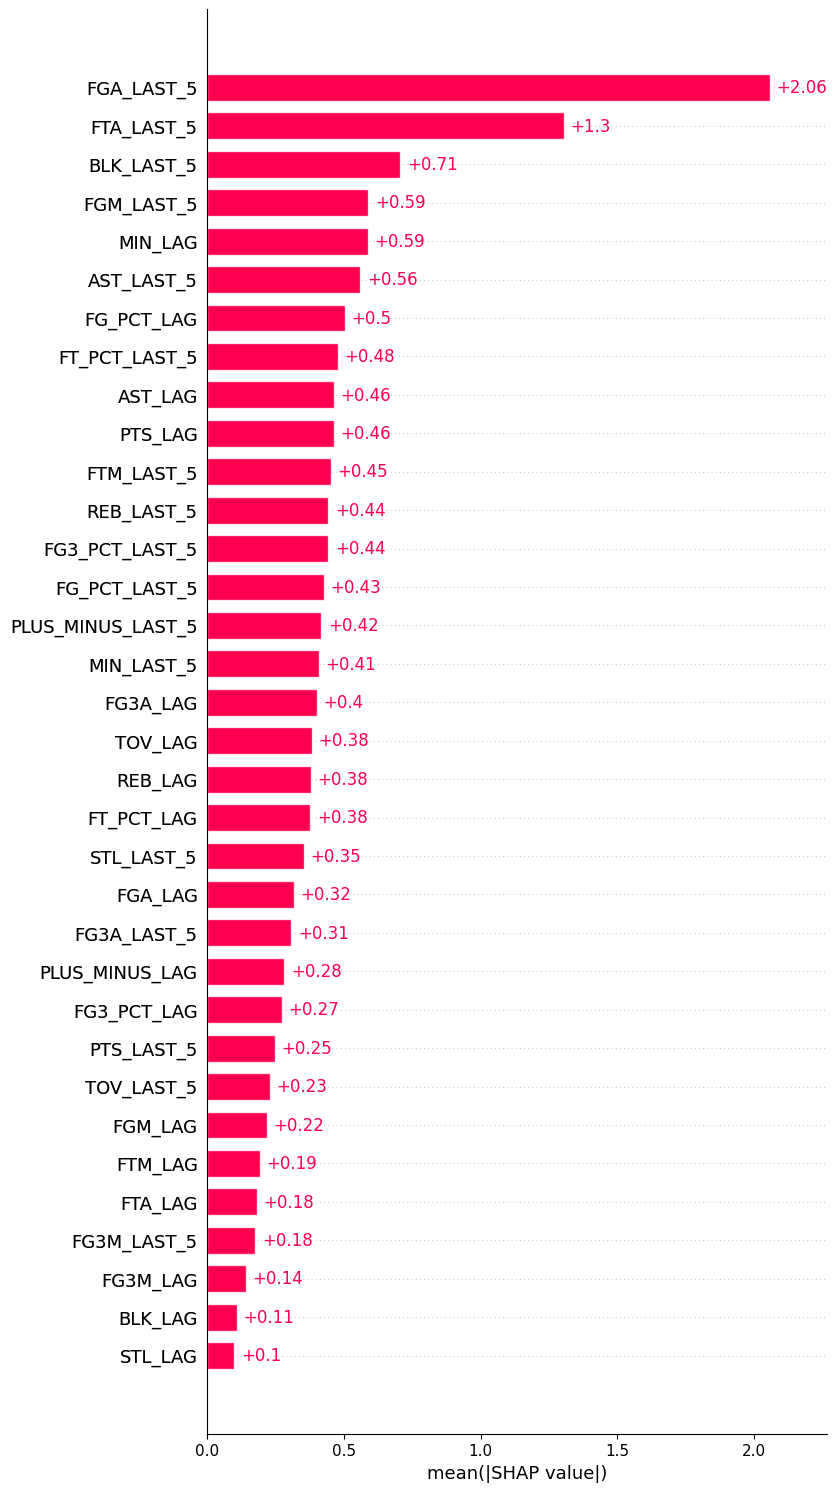

In [16]:
# Plot baseline model
shap.plots.bar(modeler.shap_values(), max_display=100)

In [17]:
# Hyperparameter Tuning
space = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': hp.quniform('max_depth', 3, 18, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
}

hpt = HyperParamTuner(modeler, space, SEED)
best = hpt.optimize(250)
best

[0]	validation_0-rmse:8.69621	validation_1-rmse:9.72926
[100]	validation_0-rmse:4.54868	validation_1-rmse:10.16287
[200]	validation_0-rmse:4.22826	validation_1-rmse:10.23738
[300]	validation_0-rmse:4.11509	validation_1-rmse:10.24590
[303]	validation_0-rmse:4.11509	validation_1-rmse:10.24590
RSME: 10.245898240477954                               
[0]	validation_0-rmse:9.15007	validation_1-rmse:9.81954                          
[100]	validation_0-rmse:6.81565	validation_1-rmse:9.83760                        
[114]	validation_0-rmse:6.81565	validation_1-rmse:9.83760                        
RSME: 9.837598707245368                                                          
[0]	validation_0-rmse:9.00639	validation_1-rmse:9.74541                          
[100]	validation_0-rmse:7.06465	validation_1-rmse:9.70202                       
[200]	validation_0-rmse:6.89611	validation_1-rmse:9.69772                       
[300]	validation_0-rmse:6.84807	validation_1-rmse:9.71299                       

{'colsample_bytree': 0.9711161372234194,
 'eta': 0.25,
 'eval_metric': 'rmse',
 'gamma': 6.519049445245967,
 'max_depth': 7.0,
 'min_child_weight': 3.0,
 'n_estimators': 621.0,
 'objective': 'reg:squarederror',
 'reg_alpha': 108.0,
 'reg_lambda': 0.33266074789728717,
 'subsample': 1.0}

In [18]:
modeler.train(best)
rmse['tuned_model'] = modeler.rmse()
rmse

[0]	validation_0-rmse:8.94204	validation_1-rmse:9.70278
[100]	validation_0-rmse:6.76242	validation_1-rmse:9.47547
[200]	validation_0-rmse:6.76242	validation_1-rmse:9.47547
[300]	validation_0-rmse:6.76242	validation_1-rmse:9.47547
[400]	validation_0-rmse:6.76242	validation_1-rmse:9.47547
[500]	validation_0-rmse:6.76242	validation_1-rmse:9.47547
[600]	validation_0-rmse:6.76242	validation_1-rmse:9.47547
[620]	validation_0-rmse:6.76242	validation_1-rmse:9.47547
RSME: 9.475472635145968


{'base_model': 10.168925407124426, 'tuned_model': 9.475472635145968}

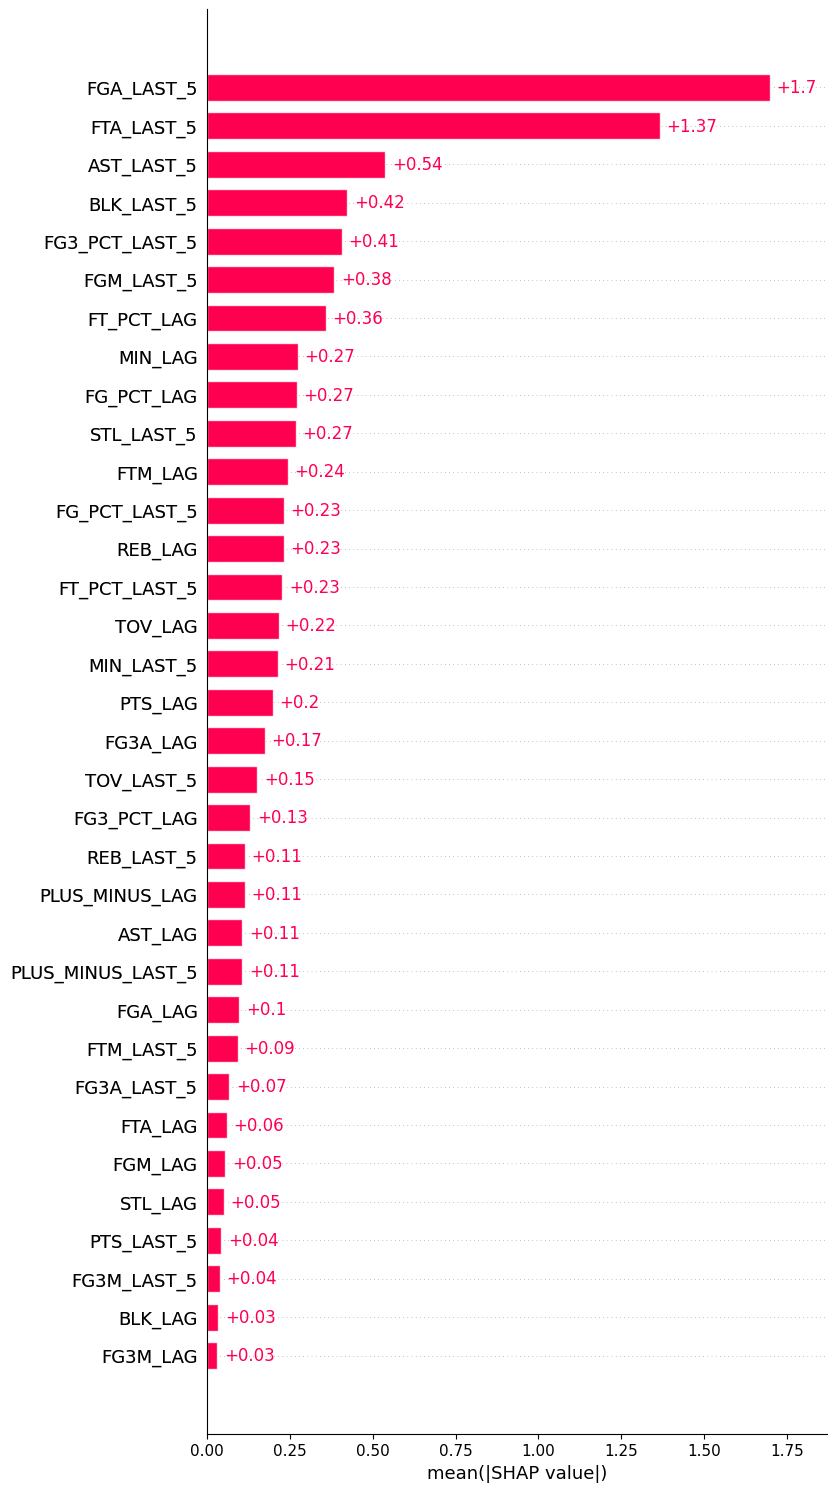

In [19]:
shap.plots.bar(modeler.shap_values(), max_display=100)